In [1]:
import sys
sys.path.append("..")
from ProbabilisticParcellation.util import *
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
# from ProbabilisticParcellation.scripts.parcel_hierarchy import analyze_parcel
import ProbabilisticParcellation.functional_profiles as fp
from copy import deepcopy
import base64


# Import Dash dependencies
import dash_bootstrap_components as dbc
from dash import Dash, dcc, html, Input, Output
from io import BytesIO
from jupyter_dash import JupyterDash
from wordcloud import WordCloud

base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

ModuleNotFoundError: No module named 'ProbabilisticParcellation.scripts.parcel_hierarchy'

## Load fine parcellation and merged models at different levels

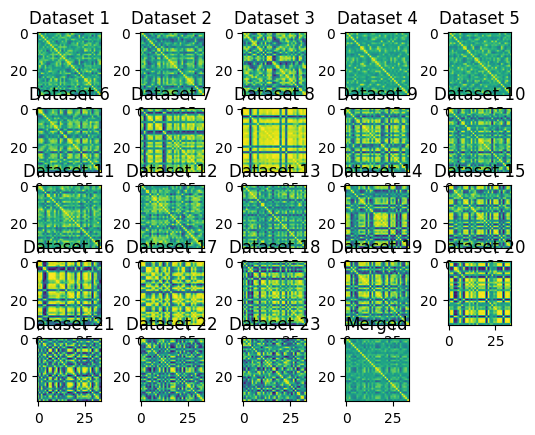

In [8]:
atlas = 'MNISymC2'

fine_model = f'/Models_03/sym_MdPoNiIbWmDeSo_space-{atlas}_K-68'
fileparts = fine_model.split('/')
split_mn = fileparts[-1].split('_')

# Get model, model info, Probabilities, parcellation and colour map
info_68, model_68 = load_batch_best(fine_model)
Prob_68 = np.array(model_68.marginal_prob())
parcel_68 = Prob_68.argmax(axis=0) + 1
cmap_68 = cm.read_cmap(f'{model_dir}/Atlases/sym_MdPoNiIbWmDeSo_space-{atlas}_K-68.cmap')

# Get labels
w_cos_sym, _, _ = cl.parcel_similarity(model_68, plot=True, sym=True)
labels_68, clusters, _ = cl.agglomative_clustering(
    w_cos_sym, sym=True, num_clusters=5, plot=False)




### Task Profiles

In [4]:
info = fp.recover_info(info_68, model_68)
profiles, conditions, cdetails = fp.get_profiles(
    model=model_68, info=info)


In [5]:
cerebellum = plot_data_flat(parcel_68, atlas, cmap=cmap_68,
                            dtype='label',
                            labels=labels_68,
                            render='plotly')


In [6]:
df = fp.get_profile_data(labels_68, info, profiles, conditions)
sessions = [2, 1, 2, 14, 2, 1, 1]
datasets = []
for d, dataset in enumerate(info.datasets):
    datasets.extend([dataset] * sessions[d])


#start of app
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.LUX])


click_region_labels = dcc.Markdown(id='clicked-region')


app.layout = html.Div([html.Div([
    html.H1('Functional Atlas Explorer'),

    html.Div([

        dcc.Graph(id="figure-cerebellum", figure=cerebellum,
                  clear_on_unhover=False),

        dcc.Tooltip(id="graph-tooltip")])
], style={'width': '49%', 'display': 'inline-block'}),

    html.Div([

        html.P('Display functions for a selected region and dataset.'),


        html.Div(children=[
            html.Label('Dataset'),
            dcc.Dropdown(datasets, id='chosen_dataset',
                         value=datasets[0], clearable=False),
        ], style={'padding': 10, 'flex': 1}),

        html.Div([
            dbc.Row([
                dbc.Col([
                    dbc.Card([
                        dbc.CardBody([
                            # html.H5('Word Cloud',className='text-center'),
                            html.Img(id="image_wc"),
                        ])
                    ])
                ], width={'size': 12, "offset": 0, 'order': 1}, style={'padding-left': 25, 'padding-right': 25}, className='text-center'),
            ])
        ]),

        html.Div([
            html.H4(id='clicked-region'),
        ]),

    ], style={'width': '49%', 'display': 'inline-block'}),

], style={'display': 'flex', 'flex-direction': 'row'})


def plot_wordcloud(df, dset, region):
    reg = 'A1L'
    # When initiliazing the website and if clickin on a null region, show no conditions
    if region is not None and region['points'][0]['text'] != '0':
        # get the region name
        reg = region['points'][0]['text']
    d = df.conditions[(df.dataset == dset) & (df.label == reg)]
    wc = WordCloud(
        background_color='white',
        width=512,
        height=384
    ).generate(' '.join(d))
    return wc.to_image()


@app.callback(

    Output('image_wc', 'src'),
    # Input(component_id='figure-cerebellum', component_property='clickData'),
    Input(component_id='image_wc', component_property='src'),
    Input(component_id='chosen_dataset', component_property='value'),
    Input(component_id='figure-cerebellum', component_property='clickData'))
def make_image(b, dset, region):
    img = BytesIO()
    plot_wordcloud(df, dset, region).save(img, format='PNG')
    return 'data:image/png;base64,{}'.format(base64.b64encode(img.getvalue()).decode())


In [7]:
if __name__=='__main__':
    app.run_server()


Dash app running on http://127.0.0.1:8050/
